<h1>General State Space Model Data Simulation</h1>
state intercepts

In [1]:
import numpy as np
from scipy.signal import lfilter
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.tools import (
    constrain_stationary_univariate, unconstrain_stationary_univariate)
import sympy as sym
import pandas as pd
import seaborn as sns
import math
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline



In [2]:
# Construct the model
class ss(sm.tsa.statespace.MLEModel):
    def __init__(self, endog):
        k_posdef = 1
        # Initialize the state space model
        super(ss, self).__init__(endog, k_states=2, k_posdef=1,
                                  initialization='diffuse')
        
        '''
        xt = exog[np.newaxis, np.newaxis, :]
        zero = np.zeros([1,1,len(exog)])
        one = np.ones([1,1,len(exog)])
        con_design = np.concatenate((one,xt), axis = 1)
        '''

        # Setup the fixed components of the state space representation
        self.ssm['design'] = np.r_[1,0]
        self.ssm['transition'] = np.eye(self.k_states,k=1)
        self.ssm['selection'] = np.eye(self.k_states,k_posdef)
        
        self.positive_parameters = slice(0,2)

    # Describe how parameters enter the model
    def update(self, params, transformed=True, **kwargs):
        params = super(ss, self).update(params, transformed, **kwargs)
        
        self.ssm['obs_cov', 0, 0] = params[0]
        self.ssm['state_cov', 0, 0] = params[1]
        #self.ssm['obs_intercept', 0, 0] = params[2]
        self.ssm['state_intercept', 0, 0] = params[4]
        self.ssm['transition',:,0] = params[2:4]
        
    @property
    def param_names(self):
        return ['H','Q','phi1','phi2','c']

    @property
    def start_params(self):
        return np.r_[[np.std(self.endog)]*2, 0.15, 0.15, self.endog[0]]
    
    def transform_params(self, unconstrained):
        constrained = unconstrained.copy()
        constrained[self.positive_parameters] = (
            constrained[self.positive_parameters] ** 2
        )
        return constrained

    def untransform_params(self, constrained):
        unconstrained = constrained.copy()
        unconstrained[self.positive_parameters] = (
            unconstrained[self.positive_parameters] ** 0.5
        )
        return unconstrained

<li>General State Space Model<ol>
    <li>Z: Design</li>
    <li>d: Observation Intercept</li>
    <li>H: Observation Covariance </li>
    <li>T: Transition</li>
    <li>c: State Intercept</li>
    <li>R: Selection</li>
    <li>Q: State Covariance</li>
    </ol>
</li>
<br>
    
\begin{equation*}
y_{t} = Z_t\alpha_t + d_t + \epsilon_t \quad\epsilon_t \sim N(0,H_t)\\
\alpha_{t+1} = T_t\alpha_t + c_t + R_t\eta_t \quad\eta_t \sim N(0,Q_t)
\end{equation*}

Example: full ss model with AR2 behavior
\begin{equation*}
y_{t} = \begin{vmatrix}
1 & 0
\end{vmatrix}\alpha_t + d_t + \epsilon_t \quad\epsilon_t \sim N(0,H_t)\\
\alpha_{t+1} = \begin{vmatrix}
\phi_1 & 1 \\
\phi_2 & 0
\end{vmatrix}\alpha_t + \begin{vmatrix}
c_t \\
0
\end{vmatrix} + \begin{vmatrix}
1 \\
0
\end{vmatrix}\eta_t \quad\eta_t \sim N(0,Q_t)
\end{equation*}


In [3]:
# True model parameters
nobs = int(1e5)
H = 4
Q = 1
d = 0
c = 2
phi = np.r_[0.5, -0.3]




In [6]:
# Simulate a time series
np.random.seed(1234)

disturbances_eta = np.random.normal(c, math.sqrt(Q), size=(nobs,))
alpha = lfilter([1], np.r_[1, -phi], disturbances_eta)
disturbances_epsilon = np.random.normal(0, math.sqrt(H), size=(nobs,))
y_t = alpha + disturbances_epsilon + d


In [7]:
mod = ss(y_t)
res = mod.fit()
print(res.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.25715D+00    |proj g|=  5.16870D-02

At iterate    5    f=  2.24679D+00    |proj g|=  9.48261D-03

At iterate   10    f=  2.24522D+00    |proj g|=  7.17185D-04

At iterate   15    f=  2.24511D+00    |proj g|=  3.18455D-03

At iterate   20    f=  2.24495D+00    |proj g|=  1.82323D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     28      1     0     0   2.254D-06   2.245D+00
  F =   2.2449503675612692     

CONVERG

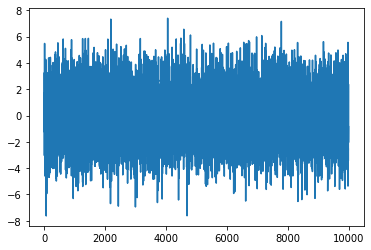

In [82]:
plt.plot(disturbances_epsilon)

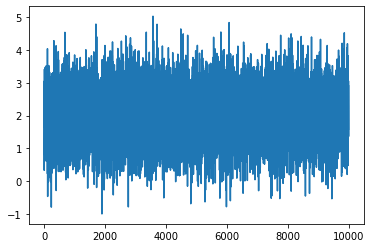

In [66]:
plt.plot(res.smoothed_state[0])

In [ ]:
"""
Univariate Local Linear Trend Model
"""
class LocalLinearTrend(sm.tsa.statespace.MLEModel):
    def __init__(self, endog):
        # Model order
        k_states = k_posdef = 2

        # Initialize the statespace
        super(LocalLinearTrend, self).__init__(
            endog, k_states=k_states, k_posdef=k_posdef,
            initialization='approximate_diffuse',
            loglikelihood_burn=k_states
        )

        # Initialize the matrices
        self.ssm['design'] = np.array([1, 0])
        self.ssm['transition'] = np.array([[1, 1],
                                       [0, 1]])
        self.ssm['selection'] = np.eye(k_states)

        # Cache some indices
        self._state_cov_idx = ('state_cov',) + np.diag_indices(k_posdef)

    @property
    def param_names(self):
        return ['sigma2.measurement', 'sigma2.level', 'sigma2.trend']

    @property
    def start_params(self):
        return [np.std(self.endog)]*3

    def transform_params(self, unconstrained):
        return unconstrained**2

    def untransform_params(self, constrained):
        return constrained**0.5

    def update(self, params, *args, **kwargs):
        params = super(LocalLinearTrend, self).update(params, *args, **kwargs)

        # Observation covariance
        self.ssm['obs_cov',0,0] = params[0]

        # State covariance
        self.ssm[self._state_cov_idx] = params[1:]

In [91]:
mod = LocalLinearTrend(yt)
res = mod.fit()
print(res.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.48342D+00    |proj g|=  5.67765D-04
  ys=-3.012E-01  -gs= 1.565E-01 BFGS update SKIPPED


 This problem is unconstrained.



At iterate    5    f=  6.21010D+00    |proj g|=  4.07811D-03

At iterate   10    f=  3.43768D+00    |proj g|=  3.09306D-01

At iterate   15    f=  3.13020D+00    |proj g|=  5.91948D-03

At iterate   20    f=  3.12672D+00    |proj g|=  1.39123D-03

At iterate   25    f=  3.12672D+00    |proj g|=  1.13442D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     67      1     1     0   7.437D-07   3.127D+00
  F =   3.1267152983234783     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                           Statespace Model Results                           
Dep. Variable:                    